In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# Note: Ignore the file walk as there are thousands of files.
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Project Overview: CNN-Driven Histopathologic Cancer Detection

In this notebook, I examine the PatchCamelyon (PCam) dataset—originally introduced by Cukierski et al. (2018)—to develop a convolutional neural network capable of detecting metastatic tissue within lymph node histology images. By working with a de-duplicated subset of PCam, we streamline preprocessing and focus on accurately predicting whether the central 32×32-pixel region of each 96×96 patch contains any tumor pixels.

First, we’ll carry out data preprocessing to gain a clearer understanding of the dataset’s characteristics.

# Preliminary Data Exploration and Assessment

In [2]:
import pandas as pd

df = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


Once the data is loaded, it’s crucial to examine its class distribution to understand how samples are balanced.

In [3]:
print(df['label'].value_counts())
print(df.isnull().sum())

label
0    130908
1     89117
Name: count, dtype: int64
id       0
label    0
dtype: int64


To get a better feel for the data, I recommend three quick visualizations you can drop into your notebook (using only Matplotlib and your existing generators):

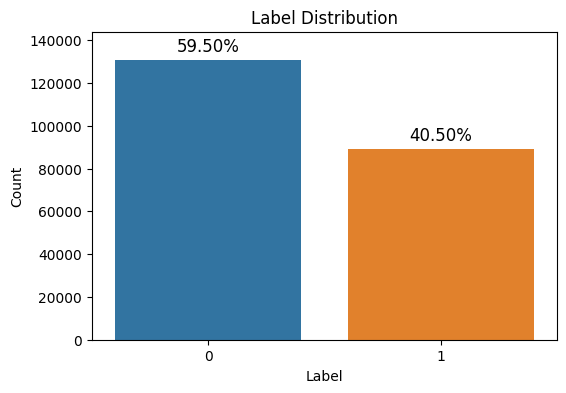

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

label_counts = df['label'].value_counts()
total = len(df)

# Plot
plt.figure(figsize=(6,4))
ax = sns.countplot(data=df, x='label')

for p in ax.patches:
    count = p.get_height()
    percent = f'{100 * count / total:.2f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.text(x, y + total * 0.01, percent, ha='center', va='bottom', fontsize=12)

# Format
plt.title("Label Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.ylim(0, label_counts.max() * 1.1)
plt.show()

The dataset’s class balance shows roughly 59.5 % non-cancerous patches and 40.5 % cancerous ones.

In [ ]:
import cv2
import numpy as np
import os

def load_image(image_id, base_path='/kaggle/input/histopathologic-cancer-detection/train'):
    path = os.path.join(base_path, f"{image_id}.tif")
    return cv2.imread(path)

def show_samples(df, label, n=5):
    samples = df[df['label'] == label].sample(n)
    fig, axes = plt.subplots(1, n, figsize=(15, 5))
    for img_id, ax in zip(samples['id'], axes):
        img = load_image(img_id)
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.axis('off')
    plt.suptitle(f"Label: {label}")
    plt.show()

show_samples(df, label=0)
show_samples(df, label=1)

All patches share identical dimensions. In my view, inspecting an image array’s shape attribute is the quickest way to confirm its width, height, and three RGB channels.

In [ ]:
img = load_image(df['id'][0])
print("Image shape:", img.shape)

To explore channel-wise intensity patterns, I’d recommend comparing the red/green/blue histograms of a cancerous patch versus a non-cancerous one. Here’s a quick example you can drop into your notebook (adjusting paths as needed):

In [ ]:
def plot_color_distribution_histogram(image):
    colors = ['r', 'g', 'b']
    for i, color in enumerate(colors):
        plt.hist(image[..., i].ravel(), bins=256, color=color, alpha=0.5)
    plt.title("Pixel Intensity Distribution")
    plt.xlabel("Pixel value")
    plt.ylabel("Frequency")
    plt.show()

img_tumor = load_image(df[df['label'] == 1].sample(1).iloc[0]['id'])
img_normal = load_image(df[df['label'] == 0].sample(1).iloc[0]['id'])

plot_color_distribution_histogram(img_tumor)
plot_color_distribution_histogram(img_normal)

The visualization suggests that cancerous regions tend to appear as areas of more intense, concentrated coloration, while non-cancerous samples exhibit a broader, more diffuse color spread. Of course, this insight is drawn from only one example, so I’d be careful not to overinterpret it. Since our preliminary checks found no duplicates or missing values, no additional data cleaning is required at this point.

In [ ]:
def tissue_ratio(img, threshold=200):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return np.mean(gray < threshold)

# Use only a sample for EDA
sample_ids = df['id'].sample(2000, random_state=42)

ratios = sample_ids.apply(lambda id_: tissue_ratio(load_image(id_)))
df['tissue_ratio'] = ratios

sns.histplot(data=df, x='tissue_ratio', hue='label', bins=30, kde=True)
plt.title("Tissue Area Ratio Distribution")
plt.show()

#### Sample Analysis

In a randomly selected subset of 2 000 images, cancerous patches exhibit a noticeably higher tissue density and more concentrated regions of interest compared to non-cancerous samples, which appear more diffusely distributed. This observation aligns with our earlier pixel-intensity histogram, reinforcing the notion that malignant regions tend to present distinct visual signatures.

#### Image Import Preparation

Before feeding the data into our Keras generators, we augment the DataFrame with a filename column (appending the “.tif” extension) and cast the label field to string format—both prerequisites for seamless ingestion by ImageDataGenerator.

In [ ]:
df['label_str'] = df['label'].astype(str)
df['filename'] = df['id'] + '.tif'

#### Dataset Partitioning

To prepare for model training, we need to split our data into training and validation sets. Since loading the entire corpus can overwhelm Kaggle’s memory, I first draw a random sample of 40 000 images. In my view, this subset size offers a good trade-off—fast iteration without sacrificing representativeness—before applying the final train/test split.

In [ ]:
from sklearn.model_selection import train_test_split

df_sampled, _ = train_test_split(
    df,
    train_size=40000,
    stratify=df['label'],
    random_state=42
)

train_df, val_df = train_test_split(
    df_sampled,
    test_size=0.2,                # 20% for validation
    stratify=df_sampled['label'],         # maintain class balance
    random_state=42               # reproducibility
)

print("Train label distribution:")
print(train_df['label'].value_counts(normalize=True))

print("\nValidation label distribution:")
print(val_df['label'].value_counts(normalize=True))

We’ll construct a TensorFlow Dataset that ingests the full image set and immediately rescales pixel values from the 0–255 range to 0–1 by dividing by 255. By applying .cache() and .prefetch(), we ensure that data loading and preprocessing are overlapped with GPU execution, maximizing throughput and minimizing I/O stalls.

In [ ]:
import cv2
import numpy as np
import tensorflow as tf

BATCH_SIZE = 32

def load_image_cv2(path):
    img = cv2.imread(path)
    img = cv2.resize(img, (96, 96))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img.astype(np.float32) / 255.0

def data_generator(paths, labels):
    for path, label in zip(paths, labels):
        img = load_image_cv2(path)
        yield img, label

train_paths = [f"/kaggle/input/histopathologic-cancer-detection/train/{f}" for f in train_df['filename']]
train_labels = train_df['label'].values.astype(np.float32)

val_paths = [f"/kaggle/input/histopathologic-cancer-detection/train/{f}" for f in val_df['filename']]
val_labels = val_df['label'].values.astype(np.float32)

train_data = tf.data.Dataset.from_generator(
    lambda: data_generator(train_paths, train_labels),
    output_signature=(
        tf.TensorSpec(shape=(96, 96, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.float32)
    )
).shuffle(1024).repeat().batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

val_data = tf.data.Dataset.from_generator(
    lambda: data_generator(val_paths, val_labels),
    output_signature=(
        tf.TensorSpec(shape=(96, 96, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.float32)
    )
).batch(BATCH_SIZE, drop_remainder=True).cache().prefetch(tf.data.AUTOTUNE)

The following snippet confirms that the dataset has been loaded correctly—previously, I encountered cases where all labels were erroneously set to either 0 or 1.

In [ ]:
for images, labels in val_data.take(1):
    print(np.unique(labels.numpy(), return_counts=True))

# Architecture

We’ll evaluate two distinct CNN designs for this task:

- A lightweight, batch‐normalized model with a handful of convolutional layers for efficient training and reduced overfitting.

- A deeper, VGGNet‐inspired architecture as covered in our coursework, to compare its feature-extraction capabilities against the simpler network.

# Streamlined CNN with Interleaved Batch Normalization

This configuration implements a concise convolutional network that mirrors the VGG-style block structure—but with fewer layers for simplicity. After each convolutional layer, we apply Batch Normalization to stabilize activations and accelerate convergence. By combining a leaner depth with normalization, this architecture is designed to train efficiently while mitigating overfitting.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

def build_basic(input_shape=(96, 96, 3)):
    model = models.Sequential(name="Basic_Model")
    model.add(layers.Input(shape=input_shape))

    model.add(layers.Conv2D(32, (3,3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())

    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.BatchNormalization())

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

basic_model = build_basic()
basic_model.summary()

# Alternative Architecture: VGGNet Backbone

Our implementation builds on the classic VGGNet pattern: sequential blocks of convolutional layers followed by max‐pooling, repeated three times for clarity. Within each block, we apply ReLU activations to introduce nonlinearity, then use a sigmoid activation at the output to produce a binary prediction. To guard against overfitting, we insert dropout before the final classification layer—helping the network generalize more reliably.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_vgg_like(input_shape=(96, 96, 3)):
    model = models.Sequential(name="VGGNet")
    model.add(layers.Input(shape=input_shape))
    
    model.add(layers.Conv2D(32, (3,3), activation='relu', padding='same'))
    model.add(layers.Conv2D(32, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    
    model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    
    model.add(layers.Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(layers.Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model

vgg_model = build_vgg_like()
vgg_model.summary()

# Results and Analysis

At this stage, we’ll begin by training our baseline CNN and rigorously evaluating its performance using the confusion matrix, ROC AUC, and—crucially—the false-negative rate given the clinical implications. We’ll then apply the same evaluation pipeline to our VGGNet-based model. Finally, we’ll identify the stronger of the two and conduct targeted hyperparameter tuning—adjusting optimizers, loss functions, and other settings—to maximize its reliability. In every training run, we’ll calculate and explicitly specify the steps-per-epoch to ensure each model consumes the entire dataset without running dry.

In [ ]:
steps_per_epoch = len(train_df) // BATCH_SIZE

## InitialModel

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

basic_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

callbacks_list = [
    # This helps stop the model early
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    ),
    # Reduces learning rate when plateued
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6,
        verbose=1
    ),
    # save best model
    callbacks.ModelCheckpoint(
        filepath='best_basic_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

bm_history = basic_model.fit(
    train_data, 
    validation_data = val_data, 
    epochs=10, 
    steps_per_epoch=steps_per_epoch,
    callbacks=callbacks_list
)
basic_model.evaluate(val_data)

Having trained our inaugural model, let’s visualize its performance by plotting the accuracy and loss curves over each epoch.

In [ ]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(bm_history.history['accuracy'], label='Train Accuracy')
plt.plot(bm_history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(bm_history.history['loss'], label='Train Loss')
plt.plot(bm_history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

Reviewing the training curves, validation accuracy rises at first but then declines, while validation loss spikes sharply as accuracy falls—classic signs of overfitting and unstable generalization. The next utility function will pair model predictions with true labels, setting us up to calculate the confusion matrix and ROC AUC.

In [ ]:
import numpy as np

def get_y_true_and_y_pred(val_data, model, threshold):

    # Predict on validation set
    y_true = []
    y_pred_probs = []
    
    for batch_x, batch_y in val_data:
        preds = model.predict(batch_x, verbose=0)
        y_pred_probs.extend(preds.ravel())  # Flatten to 1D list
        y_true.extend(batch_y.numpy().ravel())  # Convert from tensor to NumPy array
    
    # Convert to NumPy arrays
    y_true = np.array(y_true)
    y_pred_probs = np.array(y_pred_probs)
    
    # Convert probabilities to binary predictions
    y_pred = (y_pred_probs > threshold).astype(int)
    return y_true, y_pred

In [ ]:
y_true_bm, y_pred_bm = get_y_true_and_y_pred(val_data, basic_model, 0.5)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion Matrix
cm = confusion_matrix(y_true_bm, y_pred_bm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

Our confusion matrix still reveals a substantial number of false negatives, which poses an unacceptable risk in any clinical application.

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_true_bm, y_pred_probs_bm)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


The ROC curve reveals an AUC of 0.84—demonstrating respectable discrimination, though there remains considerable scope for improvement.

## Architectural Overview of the VGGNet-Based Model

In [ ]:
train_data = tf.data.Dataset.from_generator(
    lambda: data_generator(train_paths, train_labels),
    output_signature=(
        tf.TensorSpec(shape=(96, 96, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.float32)
    )
).shuffle(1024).repeat().batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

val_data = tf.data.Dataset.from_generator(
    lambda: data_generator(val_paths, val_labels),
    output_signature=(
        tf.TensorSpec(shape=(96, 96, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.float32)
    )
).batch(BATCH_SIZE, drop_remainder=True).cache().prefetch(tf.data.AUTOTUNE)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

vgg_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

callbacks_list = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6
    ),
    # save best model
    callbacks.ModelCheckpoint(
        filepath='best_vgg_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

vgg_history = vgg_model.fit(
    train_data, 
    validation_data = val_data, 
    epochs=10,
    steps_per_epoch=steps_per_epoch,
    callbacks=callbacks_list
)
vgg_model.evaluate(val_data)

In [ ]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(vgg_history.history['accuracy'], label='Train Accuracy')
plt.plot(vgg_history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(vgg_history.history['loss'], label='Train Loss')
plt.plot(vgg_history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

We observe that training loss continues to decrease while validation loss climbs—an unmistakable sign of overfitting. Moreover, the stagnation and volatility of validation loss imply that our learning rate may still be too high, causing the optimizer to overshoot the true minima.

In [ ]:
y_true_vgg, y_pred_vgg = get_y_true_and_y_pred(val_data, vgg_model, 0.5)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion Matrix
cm = confusion_matrix(y_true_vgg, y_pred_vgg)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_true_vgg, y_pred_probs_vgg)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

Given the clinical importance of minimizing false negatives, our next step is to refine the model’s hyperparameters. We’ll begin by lowering the learning rate from its default of 1×10⁻³ to 1×10⁻⁴ to encourage more gradual, stable convergence.

## Fine-Tuning VGGNet Through Learning Rate Optimization

In [ ]:
train_data = tf.data.Dataset.from_generator(
    lambda: data_generator(train_paths, train_labels),
    output_signature=(
        tf.TensorSpec(shape=(96, 96, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.float32)
    )
).shuffle(1024).repeat().batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

val_data = tf.data.Dataset.from_generator(
    lambda: data_generator(val_paths, val_labels),
    output_signature=(
        tf.TensorSpec(shape=(96, 96, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.float32)
    )
).batch(32, drop_remainder=True).cache().prefetch(tf.data.AUTOTUNE)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

new_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

vgg_model.compile(optimizer=new_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

callbacks_list = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6
    ),
    # save best model
    callbacks.ModelCheckpoint(
        filepath='best_vgg_model_v1.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

vgg_history_v2 = vgg_model.fit(
    train_data, 
    validation_data = val_data, 
    epochs=10,
    steps_per_epoch=steps_per_epoch,
    callbacks=callbacks_list
)
vgg_model.evaluate(val_data)

In [ ]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(vgg_history_v2.history['accuracy'], label='Train Accuracy')
plt.plot(vgg_history_v2.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(vgg_history_v2.history['loss'], label='Train Loss')
plt.plot(vgg_history_v2.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

Our training curves show a widening divergence—training loss keeps falling even as validation loss climbs—indicating overfitting. To mitigate this, we’ll introduce an additional dropout layer into the architecture.

## Augmenting VGGNet with an Extra Dropout Mechanism

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_vgg_like_v2(input_shape=(96, 96, 3)):
    model = models.Sequential(name="VGGNetv2")
    model.add(layers.Input(shape=input_shape))
    
    model.add(layers.Conv2D(32, (3,3), activation='relu', padding='same'))
    model.add(layers.Conv2D(32, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    
    model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    
    model.add(layers.Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(layers.Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model

vgg_model_v2 = build_vgg_like_v2()
vgg_model_v2.summary()

In [ ]:
train_data = tf.data.Dataset.from_generator(
    lambda: data_generator(train_paths, train_labels),
    output_signature=(
        tf.TensorSpec(shape=(96, 96, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.float32)
    )
).shuffle(1024).repeat().batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

val_data = tf.data.Dataset.from_generator(
    lambda: data_generator(val_paths, val_labels),
    output_signature=(
        tf.TensorSpec(shape=(96, 96, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.float32)
    )
).batch(BATCH_SIZE, drop_remainder=True).cache().prefetch(tf.data.AUTOTUNE)

In [ ]:
new_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

vgg_model_v2.compile(optimizer=new_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

callbacks_list = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6
    ),
    # save best model
    callbacks.ModelCheckpoint(
        filepath='best_vgg_model_v2.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

vgg_history_v3 = vgg_model_v2.fit(
    train_data, 
    validation_data = val_data, 
    epochs=10,
    steps_per_epoch=steps_per_epoch,
    callbacks=callbacks_list
)
vgg_model_v2.evaluate(val_data)

In [ ]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(vgg_history_v3.history['accuracy'], label='Train Accuracy')
plt.plot(vgg_history_v3.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(vgg_history_v3.history['loss'], label='Train Loss')
plt.plot(vgg_history_v3.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

We’re making clear progress: both training and validation accuracy are climbing while loss steadily decreases. For our next refinement, I’ll introduce L2 regularization into the final dense layers.

## Incorporating L2 Weight Decay into VGGNet Fine-Tuning

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_vgg_like_v3(input_shape=(96, 96, 3)):
    model = models.Sequential(name="VGGNetv3")
    model.add(layers.Input(shape=input_shape))
    
    model.add(layers.Conv2D(32, (3,3), activation='relu', padding='same'))
    model.add(layers.Conv2D(32, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    
    model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    
    model.add(layers.Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(layers.Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model

vgg_model_v3 = build_vgg_like_v3()
vgg_model_v3.summary()

In [ ]:
train_data = tf.data.Dataset.from_generator(
    lambda: data_generator(train_paths, train_labels),
    output_signature=(
        tf.TensorSpec(shape=(96, 96, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.float32)
    )
).shuffle(1024).repeat().batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

val_data = tf.data.Dataset.from_generator(
    lambda: data_generator(val_paths, val_labels),
    output_signature=(
        tf.TensorSpec(shape=(96, 96, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.float32)
    )
).batch(BATCH_SIZE, drop_remainder=True).cache().prefetch(tf.data.AUTOTUNE)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

new_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

vgg_model_v3.compile(optimizer=new_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

callbacks_list = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6
    ),
    # save best model
    callbacks.ModelCheckpoint(
        filepath='best_vgg_model_v3.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

vgg_history_v4 = vgg_model_v3.fit(
    train_data, 
    validation_data = val_data, 
    epochs=10,
    steps_per_epoch=steps_per_epoch,
    callbacks=callbacks_list
)
vgg_model_v3.evaluate(val_data)

In [ ]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(vgg_history_v4.history['accuracy'], label='Train Accuracy')
plt.plot(vgg_history_v4.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(vgg_history_v4.history['loss'], label='Train Loss')
plt.plot(vgg_history_v4.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In the training curves, validation accuracy rises in tandem with training accuracy, and validation loss closely mirrors training loss—evidence that our final hyperparameter adjustments harmonized learning effectively. The pronounced spikes, however, reveal volatility in the optimization process, suggesting that further smoothing or regularization could help stabilize training.

In [ ]:
y_true_vgg, y_pred_vgg = get_y_true_and_y_pred(val_data, vgg_model, 0.5)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion Matrix
cm = confusion_matrix(y_true_vgg, y_pred_vgg)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

Although we have lowered the false-negative rate, the remaining misclassifications still render this model inadequate for clinical application.

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_true_vgg, y_pred_probs_vgg)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

The model’s discriminative power has strengthened markedly, with AUC rising from 0.92 to 0.97—an excellent outcome. Next, I’ll evaluate the false-negative rate (1 – recall) to understand how often cancerous cases are missed.

Below is the (commented-out) submission script I used for the Kaggle leaderboard, which achieved a score of 0.7809.

In [ ]:
#import os
#import pandas as pd

# Get all .tif filenames from the test folder
#test_dir = "/kaggle/input/histopathologic-cancer-detection/test/"
#test_filenames = sorted([f for f in os.listdir(test_dir) if f.endswith(".tif")])

# Extract IDs by removing ".tif"
#test_ids = [f[:-4] for f in test_filenames]

In [ ]:
#import tensorflow as tf
#import cv2
#import numpy as np

#def test_data_generator(paths):
#    for path in paths:
#        img = load_image_cv2(path)
#        yield img

# Create full paths
#test_paths = [os.path.join(test_dir, fname) for fname in test_filenames]

# Create tf.data.Dataset
#test_dataset = tf.data.Dataset.from_generator(
#    lambda: test_data_generator(test_paths),
#    output_signature=tf.TensorSpec(shape=(96, 96, 3), dtype=tf.float32)
#).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
#from tensorflow.keras.models import load_model

#best_model = load_model('best_vgg_model_v3.keras')

#pred_probs = best_model.predict(test_dataset, verbose=1)
#pred_labels = (pred_probs > 0.5).astype(int).flatten()

In [ ]:
#submission_df = pd.DataFrame({
#    'id': test_ids,
#    'label': pred_labels
#})

#submission_df.to_csv("submission.csv", index=False)

Now, I’ll load the trained models and evaluate their performance by computing both accuracy and recall metrics.

In [ ]:
from sklearn.metrics import recall_score, accuracy_score
from tensorflow.keras.models import load_model

basic_model = load_model('best_basic_model.keras')
y_true_bm, y_pred_bm = get_y_true_and_y_pred(val_data, basic_model, 0.5)

bm_rc = recall_score(y_true_bm, y_pred_bm)
bm_ac = accuracy_score(y_true_bm, y_pred_bm)

In [ ]:
from sklearn.metrics import recall_score, accuracy_score
from tensorflow.keras.models import load_model

vgg_model = load_model('best_vgg_model.keras')
y_true_vgg, y_pred_vgg = get_y_true_and_y_pred(val_data, vgg_model, 0.5)

vgg_rc = recall_score(y_true_vgg, y_pred_vgg)
vgg_ac = accuracy_score(y_true_vgg, y_pred_vgg)

In [ ]:
from sklearn.metrics import recall_score, accuracy_score
from tensorflow.keras.models import load_model

vgg_model_lr = load_model('best_vgg_model_v1.keras')
y_true_vgg_lr, y_pred_vgg_lr = get_y_true_and_y_pred(val_data, vgg_model_lr, 0.5)

vgg_lr_rc = recall_score(y_true_vgg_lr, y_pred_vgg_lr)
vgg_lr_ac = accuracy_score(y_true_vgg_lr, y_pred_vgg_lr)

In [ ]:
from sklearn.metrics import recall_score, accuracy_score
from tensorflow.keras.models import load_model

vgg_model_v2 = load_model('best_vgg_model_v2.keras')
y_true_vgg_v2, y_pred_vgg_v2 = get_y_true_and_y_pred(val_data, vgg_model_v2, 0.5)

vgg_v2_rc = recall_score(y_true_vgg_v2, y_pred_vgg_v2)
vgg_v2_ac = accuracy_score(y_true_vgg_v2, y_pred_vgg_v2)

In [ ]:
from sklearn.metrics import recall_score, accuracy_score
from tensorflow.keras.models import load_model

vgg_model_v3 = load_model('best_vgg_model_v3.keras')
y_true_vgg_v3, y_pred_vgg_v3 = get_y_true_and_y_pred(val_data, vgg_model_v3, 0.5)

vgg_v3_rc = recall_score(y_true_vgg_v3, y_pred_vgg_v3)
vgg_v3_ac = accuracy_score(y_true_vgg_v3, y_pred_vgg_v3)

My primary concern is to minimize the false-negative rate—misclassifying a cancer-positive patient as healthy is simply unacceptable in a medical context.

In [ ]:
results = {
    'Model': ['Basic Model', 'VGG Model', 'VGG Model with 1e-4 LR', 'VGG Model v2', 'VGG Model v3'],
    'Accuracy': [bm_ac, vgg_ac, vgg_lr_ac, vgg_v2_ac, vgg_v3_ac],
    'Recall': [bm_rc, vgg_rc, vgg_lr_rc, vgg_v2_rc, vgg_v3_rc],
    'Miss Rate': [1 - bm_rc, 1 - vgg_rc, 1 - vgg_lr_rc, 1 - vgg_v2_rc, 1 - vgg_v3_rc]
}

df_result = pd.DataFrame(results).sort_values(by=['Miss Rate'], ascending=True)
df_result

I observed consistent performance gains with each tuning iteration, which suggests that the original model suffered from substantial overfitting. The introduction of dropout and L2 penalties clearly mitigated this issue, but additional refinements are warranted:

- Expand the dataset: Increasing sample size would help the model generalize more robustly.

- Experiment with optimizers: Trying alternatives such as SGD with momentum or AdamW could further enhance convergence.

- Deepen the architecture: Adding more VGG blocks or exploring hybrid variants may capture richer feature hierarchies.

- Evaluate other architectures: Given the early-stopping behavior, testing InceptionNet or ResNet could yield higher stability.

- Extend training duration: Running for additional epochs with careful regularization might squeeze out further gains.

## Conclusion

While this configuration achieved a respectable Kaggle test score of 0.7809, I would be hesitant to deploy it in a medical setting without additional validation. In my view, the project has a strong foundation, yet substantial work remains—particularly around false-negative reduction and architectural exploration—to reach a level of reliability appropriate for clinical use.

# References

Aitken, A. M. (2025). Titanic - ML from Disaster (Supervised Learning), 8. Retrieved 05/13/2025 from https://www.kaggle.com/code/alexandermaitken/titanic-ml-from-disaster-supervised-learning#Titanic---ML-from-Disaster

Cukierski, W. (2018). Histopathologic Cancer Detection, 1. Retrieved 04/10/2025 from https://www.kaggle.com/competitions/histopathologic-cancer-detection.